# Homework 07

### Preparation...

Run this code from the lecture to be ready for the exercises below!

In [1]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

In [2]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [3]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(download_dir)

Concatenating 68 csv files...
Loading done.


In [4]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate()
    #ret_data = ret_data.set_index("DateTime")
    ret_data = ret_data.resample("1h").mean().interpolate()
    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2015-01-01":"2019-12-31"]

## Exercise 1

Explain the following terms:

**Input feature:** variable(s), or attribute(s) that characterize our variable of interest; i.e. known/independent variable(s)

**Output feature:** variable of interest; i.e. the unknown/dependent variable

**Fit a function to data:** process of specifying the model that best respresents the dependencies between input and output feature

**Training data:** Split of the dataset (usually about 80%) which is used for model/function fitting.

**Test data:** Split of the dataset (usually about 20%) which is used for testing the accuracy of a fitted model/function.


    

## Exercise 2

In lecture07 we created a plot of the ratio of actual load and predicted load for Austria step by step (Exercise 04). Now put all of this together in one function which takes one parameter `country` as input and calculates and plots the figure of Exercise 04 for this country! The model should be trained on 2015-2019 data and then you should predict for 2020 and compare it to observations. Also do a training/test split and print the R2 for both datasets.

Apply the function to the following countries and show the results in one plot: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(1) Print the country name. Get the data for the specific country using ```get_hourly_country_data``` from the lecture and extract two periods, i.e 2015-2019 and 2020 in two separate dataframes.

(2) Define X (the input features, i.e. the indicators for time) and Y (i.e. the output feature, the electricity load). Observe that for training, we use the period 2015-2019.

(3) Do a train/test split

(4) Fit the input features to the output feature using a ```RandomForestRegressor```

(5) Predict the output with the training data and the test data and compute the R^2 for both!

(6) Print the R^2.

(7) Create a new variable ```X_2020``` which contains the input features for the year 2020.

(8) Predict with your model the load for 2020.

(9) Assign your prediction back to the dataframe in a new column and calculate the monthly mean for prediction and for observed load. You might need to copy the dataframe first by doing something like `power_demand_hourly = power_demand_hourly.copy()` (otherwise it might be just a slice of the complete time range and then you can't add a column for some rows only).

(10) Plot the ratio of load and prediction. With ```label=country```, you can add a label to your plot for making a legend.

(11) Execute the function for the following countries: Austria, Germany, Switzerland, Italy, Spain, Sweden, United Kingdom.

(12) After calling the functions, use ```plt.legend()``` to show a legend.

In [5]:
def prop_pred_observed(inp_country):
    print(f"Filtering data for {inp_country}...")

    # Get country data
    power_demand_country_hourly_p1 = get_hourly_country_data(power_demand, country)["2015-01-01":"2019-12-31"]
    power_demand_country_hourly_p2 = get_hourly_country_data(power_demand, country)["2020-01-01":]
    print(f"Data for {inp_country} filtered.")
     
    # define input features (time indicators)
    X = np.array([
        power_demand_country_hourly_p1.index.dayofyear.values,
        power_demand_country_hourly_p1.index.weekday.values,
        power_demand_country_hourly_p1.index.hour.values
        ]).T
    # define output feature (electricity load)
    Y = power_demand_country_hourly_p1["TotalLoadValue"].values

    # split into training and testing data
    X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=.2)
    
    # train model
    forest_split_set = ensemble.RandomForestRegressor()
    forest_split_set.fit(X_training, Y_training)

    # prediction
    prediction_training = forest_split_set.predict(X_training)
    prediction_test = forest_split_set.predict(X_test)

    # calculate and print R2
    r2_training = r2_score(Y_training, prediction_training)
    print(f"R2 for {inp_country}:\nR2 for training dataset {r2_training}")
    r2_test = r2_score(Y_test, prediction_test)
    print(f"R2 for test dataset {r2_test}\n")

    # input features for 2020
    X_2020 = np.array([
        power_demand_country_hourly_p2.index.dayofyear.values,
        power_demand_country_hourly_p2.index.weekday.values,
        power_demand_country_hourly_p2.index.hour.values
        ]).T

    # predict 2020 load and assign to df
    power_demand_country_hourly_p2["prediction_2020"] = forest_split_set.predict(X_2020)

    #power_demand_country_hourly_p2 = power_demand_country_hourly_p2.copy()
    #power_demand_country_hourly_p2["mean_1m"] = power_demand_country_hourly_p2.TotalLoadValue.resample("1m").ffil().mean()
#    power_demand_country_hourly_p2["predicted_mean_1m"] = power_demand_country_hourly_p2.prediction_2020.resample("1m").mean()

    # calculate monthly mean
    proportion = power_demand_country_hourly_p2.TotalLoadValue.resample("1m").mean() / power_demand_country_hourly_p2.prediction_2020.resample("1m").mean()

    proportion.plot(label=inp_country)
    
    del power_demand_country_hourly_p1, power_demand_country_hourly_p2 # don't need this dataframes anymore
    return (r2_training, r2_test)

Filtering data for Austria...
Data for Austria filtered.
R2 for Austria:
R2 for training dataset 0.9917956873776639
R2 for test dataset 0.9419806769225739

Filtering data for Germany...
Data for Germany filtered.
R2 for Germany:
R2 for training dataset 0.9934908359596634
R2 for test dataset 0.950676141011304

Filtering data for Switzerland...
Data for Switzerland filtered.
R2 for Switzerland:
R2 for training dataset 0.9834023666301505
R2 for test dataset 0.8633344316454574

Filtering data for Italy...
Data for Italy filtered.
R2 for Italy:
R2 for training dataset 0.9961613339082563
R2 for test dataset 0.9726524224325397

Filtering data for Spain...
Data for Spain filtered.
R2 for Spain:
R2 for training dataset 0.9926788095519367
R2 for test dataset 0.9470735065050642

Filtering data for Sweden...
Data for Sweden filtered.
R2 for Sweden:
R2 for training dataset 0.9923226138023876
R2 for test dataset 0.9473436243797506

Filtering data for United Kingdom...
Data for United Kingdom filtere

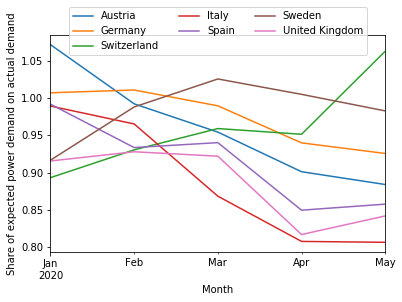

In [7]:
country_list = ["Austria", "Germany", "Switzerland", "Italy", "Spain", "Sweden", "United Kingdom"]
r2 = [] # save R2 for answering questions from Exercise 3


## predict/plot values for each country
for country in country_list:
    r2_training, r2_test = prop_pred_observed(country)
    r2.append([r2_training, r2_test])

    del r2_training, r2_test

# Create pandas dataframe with results
r2 = pd.DataFrame(r2, columns=["R2_training", "R2_test"])
r2["Country"] = country_list
r2 = r2.set_index("Country")
r2["Difference_training_test"] = r2.R2_training - r2.R2_test

print(country_list)
plt.xlabel("Month")
plt.ylabel("Share of expected power demand on actual demand")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3
    )
plt.show()

## Exercise 3
Answer the following questions:

In [8]:
r2

,R2_training,R2_test,Difference_training_test
Country,,,
Austria,0.991796,0.941981,0.049815
Germany,0.993491,0.950676,0.042815
Switzerland,0.983402,0.863334,0.120068
Italy,0.996161,0.972652,0.023509
Spain,0.992679,0.947074,0.045605
Sweden,0.992323,0.947344,0.044979
United Kingdom,0.977940,0.851133,0.126807


(1) Which country had the strongest decline in electricity consumption?

<p>
observed < predicted value ... decline in electricity consumption (observed / predicted < 1)
<br />
observed > predicted value ... increase in electricity consumption (observed / predicted > 1)
</p>

<p>
Result shows:
From February, Italy has the largest decline in electricity consumption, followed by UK and Spain.
</p>

(2) For which country does the fit work best?

In [14]:
r2[r2.R2_test == r2.R2_test.max()]

,R2_training,R2_test,Difference_training_test
Country,,,
Italy,0.996161,0.972652,0.023509


Italy -> highest R2 value for training dataset -> best fit

(3) Where is the difference of R2 between training data and test data the largest? What does that mean?

In [15]:
r2.Difference_training_test.index.max()

'United Kingdom'

The difference of R2 for training and test data is largest for United Kingdom.
<br />


(4) Look into the data of the country with the largest difference in the R2 of the training and the test data. Can you explain what is happening there? Might this effect our model?

In [ ]:
power_demand_uk = get_hourly_country_data(power_demand, "United Kingdom")["2015-01-01":"2019-12-31"]


In [ ]:
power_demand_uk.TotalLoadValue.plot()

Seems like there is a linear trend in power consumption between October 2017 and December 2017, as well as in the 2nd quater of 2018. Maybe there was lack of data and these periods where interpolated?.

## Exercise 4

The difference between model prediction and actual observation may help understanding how people behaved during the lockdown. In this exercise, you should come up with your own hypothesis of how people behaved and how this affected power consumption. You may, e.g., look into demand on different weekdays or in different hours. Once you have a hypothesis and a theory, why this hypothesis may be valid, test it with the model: is your hypothesis covered by what you observe in the load data?

**Hypothesis**: The predicted power consumption during COVID-19 lockdown for Austria shows a larger decline in power consumption during weekdays compared to weekends.

In [16]:
def model_power_demand_2020(inp_country):
    print(f"Filtering data for {inp_country}...")

    # Get country data
    power_demand_country_hourly_p1 = get_hourly_country_data(power_demand, country)["2015-01-01":"2019-12-31"]  
    power_demand_country_hourly_p2 = get_hourly_country_data(power_demand, country)["2020-01-01":]  
     
    # define input features (time indicators)
    X = np.array([
        power_demand_country_hourly_p1.index.dayofweek.values
        ]).T
    # define output feature (electricity load)
    Y = power_demand_country_hourly_p1["TotalLoadValue"].values

    # split into training and testing data
    X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=.2)
    
    # train model
    forest_split_set = ensemble.RandomForestRegressor()
    forest_split_set.fit(X_training, Y_training)

    # prediction
    prediction_training = forest_split_set.predict(X_training)
    prediction_test = forest_split_set.predict(X_test)

    # calculate and print R2
    r2_training = r2_score(Y_training, prediction_training)
    print(f"R2 for {inp_country}:\nR2 for training dataset {r2_training}")
    r2_test = r2_score(Y_test, prediction_test)
    print(f"R2 for test dataset {r2_test}\n")

    # input features for 2020
    X_2020 = np.array([
        power_demand_country_hourly_p2.index.dayofweek.values
        ]).T

    # predict 2020 load and assign to df
    power_demand_country_hourly_p2["prediction_2020"] = forest_split_set.predict(X_2020)

    return (r2_training, r2_test, power_demand_country_hourly_p2)

In [17]:
r2 = []

## predict/plot values for each country
for country in country_list[:1]:
    r2_training, r2_test, power_demand_2020 = model_power_demand_2020(country)
    r2.append([r2_training, r2_test])

    del r2_training, r2_test

# Create pandas dataframe with results
r2 = pd.DataFrame(r2, columns=["R2_training", "R2_test"])
r2["Country"] = country_list[:1]
r2 = r2.set_index("Country")
r2["Difference_training_test"] = r2.R2_training - r2.R2_test


Filtering data for Austria...
R2 for Austria:
R2 for training dataset 0.17854160018807064
R2 for test dataset 0.18509534705105202



DateTime
4    0.848778
Name: obs_vs_pred, dtype: float64


Text(0.5, 1.0, 'Effect of power consumption 2020 in Austria by weekday')

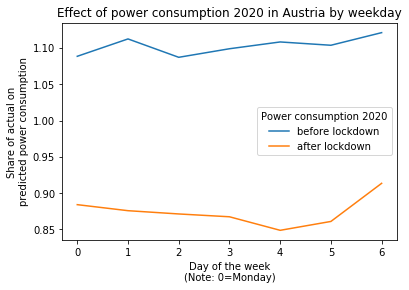

In [32]:
power_demand_2020["day_of_week"] = power_demand_2020.index.day_name()
power_demand_2020["obs_vs_pred"] = power_demand_2020.TotalLoadValue / power_demand_2020.prediction_2020

# split dataset for 2020
before_lockdown = power_demand_2020[power_demand_2020.index <= "2020-03-15"]
after_lockdown = power_demand_2020[power_demand_2020.index > "2020-03-15"]  # maybe lockdown was 2020-03-17?

mean_diff_pred_vs_obs = after_lockdown.obs_vs_pred.groupby(after_lockdown.index.weekday).mean()
print(mean_diff_pred_vs_obs[mean_diff_pred_vs_obs == mean_diff_pred_vs_obs.min()])


before_lockdown.obs_vs_pred.groupby(before_lockdown.index.weekday).mean().plot(label="before lockdown")
after_lockdown.obs_vs_pred.groupby(after_lockdown.index.weekday).mean().plot(label= "after lockdown")
plt.legend(title="Power consumption 2020")
plt.xlabel("Day of the week\n(Note: 0=Monday)")
plt.ylabel("Share of actual on\npredicted power consumption")
plt.title("Effect of power consumption 2020 in Austria by weekday")

The analysis of the difference in observed and predicted power consumption during COVID-19 lockdown phase (i.e. orange line in the graph) shows a larger decline from day 0 until day 4 compared to day 5 and day 6, with the largest decline on day 4 (Friday).
--> Hypothesis, that the decline in power consumption is larger on weekdays compared to weekends confirmed.

## Exercise 5

Download ERA5 temperature data for the next lecture.

First install necessary dependencies `xarray` and `cdsapi`:

In [ ]:
conda install --yes xarray
conda install --yes -c conda-forge cdsapi

The [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) provides [reanalysis climate data](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20))). We are going to download [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form) data and use the [temperature 2m above ground values](https://apps.ecmwf.int/codes/grib/param-db?id=167).

Register for the CDS API and install the API key by following [this guide](https://cds.climate.copernicus.eu/api-how-to). You don't need to run `pip install cdsapi`, this has been done in the cell above already using conda.

In [33]:
import cdsapi

c = cdsapi.Client()

In [147]:
# Add the path to the lecture repository here:
PATH_TO_LECTURE_REPO = '../../lecture-scientific-computing'

if not os.path.isdir(Path(PATH_TO_LECTURE_REPO) / 'lecture00-introduction'):
    raise RuntimeError(f"Wrong path to lecture repository: PATH_TO_LECTURE_REPO = {PATH_TO_LECTURE_REPO}")

We'll download data from 2015 to 2020 in a bounding box which covers all countries we used so far for our analysis.
To make the download a bit faster, we'll use a [0.5° grid](https://confluence.ecmwf.int/display/CKB/ERA5%3A+Web+API+to+CDS+API) instead of the 0.1° grid. This will download approximately 500MB. The download might take a couple of hours, because the data is prepared on their servers before it can be downloaded.

In [160]:
filename = Path(PATH_TO_LECTURE_REPO) / 'data' / 'temperatures_era5.nc'

north, west, south, east = 70.,-13.5, 35.5, 24.5

c.retrieve(
    'reanalysis-era5-land',
    {
        'format': 'netcdf',
        'variable': '2m_temperature',
        'area': [
            north, west, south, east
        ],
        'grid': [0.5, 0.5],  # grid in 0.5deg steps in longitude/latitude
        'day': [f"{day:02d}" for day in range(1, 32)],
        'time': [f"{hour:02d}:00" for hour in range(24)],
        'month': [f"{month:02d}" for month in range(1, 13)],
        'year': [str(year) for year in range(2015, 2021)],
    },
    f"{filename}.part")

# this prevents you from accidentally using broken files:
os.rename(f"{filename}.part", filename)

## Exercise 6

Load the file downloaded in exercise 3 and plot the temperature for one location. This is also a test if the download was successful. To load the file import the library `xarray`. Typically it is imported by using `import xarray as xr`. Then load the file using the command `xr.load_dataset(filename)`. Check the type of the return value. Then select the data variable `t2m` (temperature at 2m), select the values for `longitude=16.5` and `latitude=48` by using `temperatures_dataset.t2m.sel(longitude=16.5, latitude=48.)`. Then plot the result by calling `.plot()` on the resulting object.

Does the result look reasonable?

In [34]:
import xarray as xr


In [35]:
temperatures_dataset = xr.load_dataset("../../lecture-scientific-computing/data/temperatures_era5.nc")

# check object type
type(temperatures_dataset)


xarray.core.dataset.Dataset

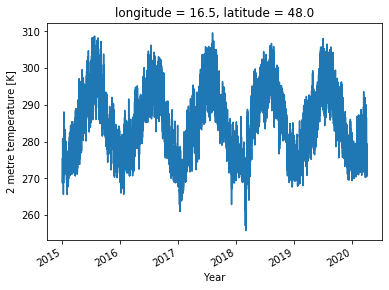

In [43]:

temperatures_dataset.t2m.sel(longitude=16.5, latitude=48.)
temperatures_dataset.t2m.sel(longitude=16.5, latitude=48.).plot()
plt.xlabel("Year")
plt.show()

# Result looks reasonable, because it shows the seasonality of temperature 2m above ground, i.e. lower temperatures during winter months and higher temperatures during summer months